In [85]:
# manipulating data
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# pre processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# hypertuning
import optuna

# metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Loading and Understanding the dataset

In [2]:
df = pd.read_csv('data/heart-disease.csv')
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Features description:
1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
- 0: Typical angina: chest pain related decrease blood supply to the heart
- 1: Atypical angina: chest pain not related to heart
- 2: Non-anginal pain: typically esophageal spasms (non heart related)
- 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
- serum = LDL + HDL + .2 * triglycerides
- above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
- 0: Nothing to note
- 1: ST-T Wave abnormality
can range from mild symptoms to severe problems
signals non-normal heart beat
- 2: Possible or definite left ventricular hypertrophy
Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
- looks at stress of heart during excercise
- unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
- 0: Upsloping: better heart rate with excercise (uncommon)
- 1: Flatsloping: minimal change (typical healthy heart)
- 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
- colored vessel means the doctor can see the blood passing through
- the more blood movement the better (no clots)
13. thal - thalium stress result
- 1,3: normal
- 6: fixed defect: used to be defect but ok now
- 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [3]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Here we can see that some columns like `sex` and `cp` (chest pain) are incorrectly set as int, when it should be a category. Having cp = 1 indicates atypical angina and cp = 2 non anginal pain, and having them as integers could make some machine learning algorithm interpret cp = 2 as 2 * cp = 1, what doesn't make sense, so it's important to fix the datatypes.

In [4]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'target']
df[categorical_columns] = df[categorical_columns].astype('category')
df.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca             int64
thal        category
target      category
dtype: object

In [5]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        303 non-null    int64   
 12  thal      303 non-null    category
 13  target    303 non-null    category
dtypes: category(8), float64(1), int64(5)
memory usage: 17.8 KB


No missing values.

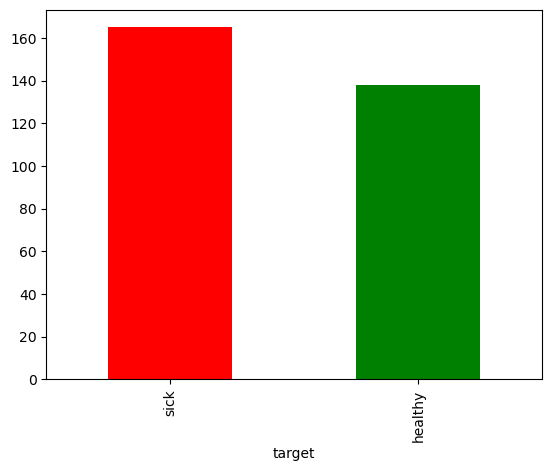

In [7]:
df['target'].value_counts().plot(kind='bar', color=['red', 'green'])

plt.xticks(ticks=[0, 1], labels=['sick', 'healthy'])
plt.show()

The classes are balanced.

### Exploring the data

Visualizing the data and their relashionships

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_1312\2076872420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sex_target = df[df['target'] == 1].groupby('sex')['target'].count() / df['sex'].value_counts()


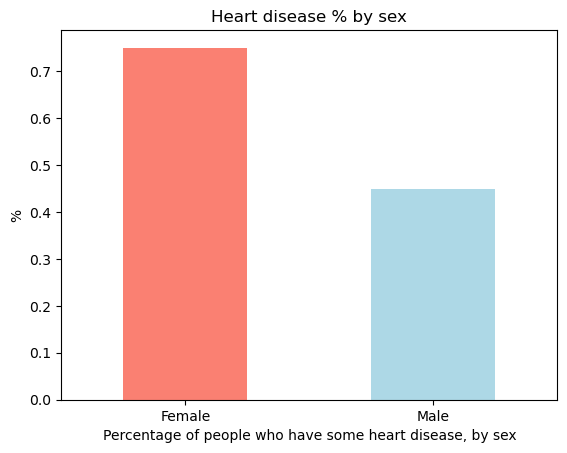

In [8]:
sex_target = df[df['target'] == 1].groupby('sex')['target'].count() / df['sex'].value_counts()

sex_target.plot(kind='bar', color=['salmon', 'lightblue'])

plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], rotation=0)

plt.ylabel('%')
plt.title('Heart disease % by sex')
plt.xlabel('Percentage of people who have some heart disease, by sex')
plt.show()

Over 70% of the women in this dataset have heart disease problems, while most of the men don't have, so if we were to guess, at random, if a female has a heart disease, we could guess she has with over 70% accuracy. This can be a metric to compare with our machine learning model, later.

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_1312\1904907072.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_age = df[df['target'] == 1].groupby('Age Group')['target'].count() / df['Age Group'].value_counts()


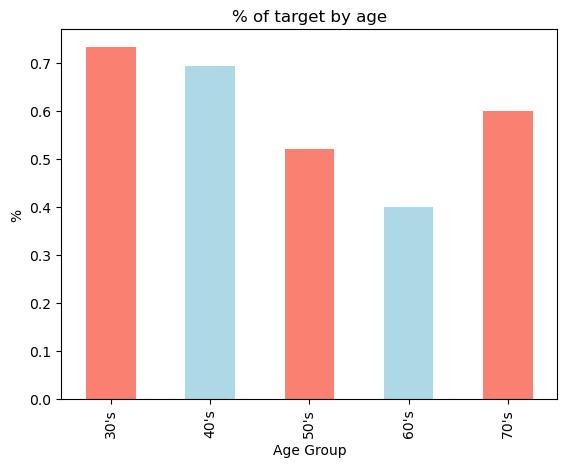

In [9]:
values = [29, 39, 49, 59, 69, 79]
labels = ['30\'s', '40\'s', '50\'s', '60\'s', '70\'s']

df['Age Group'] = pd.cut(df['age'], bins=values, labels=labels, right=True)

percentage_age = df[df['target'] == 1].groupby('Age Group')['target'].count() / df['Age Group'].value_counts()
percentage_age.plot(kind='bar', color=['salmon', 'lightblue'])

plt.xlabel('Age Group')
plt.ylabel('%')
plt.title('% of target by age')
plt.show()

We can observe that, by age, the most people that have heart diseases are people in their 30's (over 70%) and 40's (almost 70%), decreasing the probability as they grow older (except in their 70's).

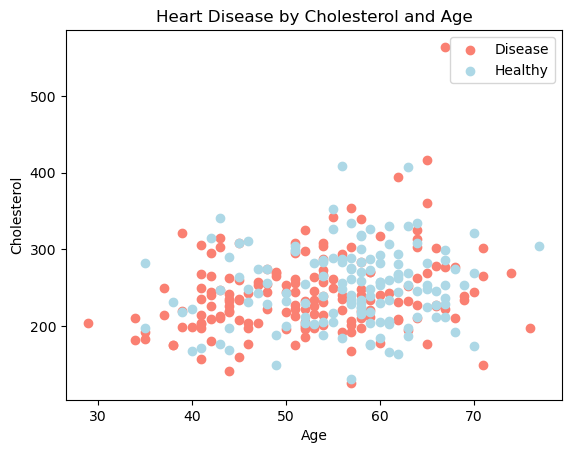

In [10]:
plt.scatter(df['age'][df['target'] == 1], df['chol'][df['target'] == 1], c='salmon')
plt.scatter(df['age'][df['target'] == 0], df['chol'][df['target'] == 0], c='lightblue')

plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.legend(['Disease', 'Healthy'])
plt.title('Heart Disease by Cholesterol and Age')
plt.show()

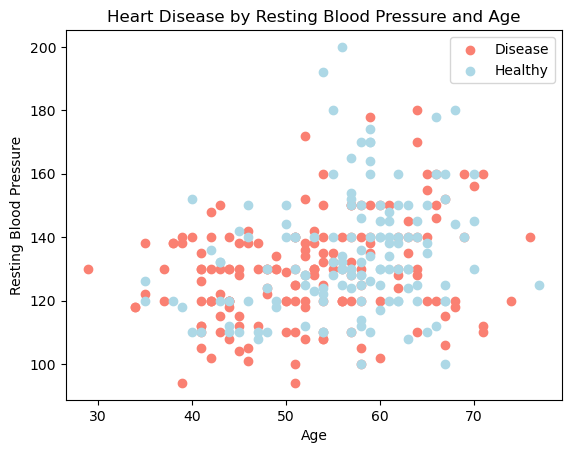

In [11]:
plt.scatter(df['age'][df['target'] == 1], df['trestbps'][df['target'] == 1], c='salmon')
plt.scatter(df['age'][df['target'] == 0], df['trestbps'][df['target'] == 0], c='lightblue')

plt.xlabel('Age')
plt.ylabel('Resting Blood Pressure')
plt.legend(['Disease', 'Healthy'])
plt.title('Heart Disease by Resting Blood Pressure and Age')
plt.show()

It doesn't appear to have a direct relationship between the cholesterol levels or Resting Blood Pressure and the presence of a heart disease.

In [12]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,Age Group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,60's
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,30's
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,40's
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,50's
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,50's
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,50's
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,50's
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,40's
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,50's
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,50's


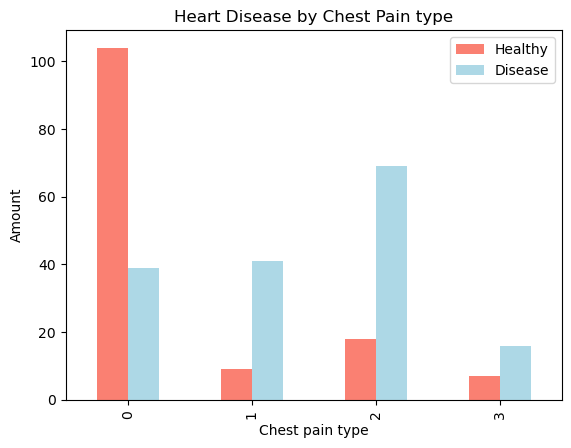

In [13]:
pd.crosstab(df.cp, df.target).plot(kind='bar', color=['salmon', 'lightblue'])
plt.title("Heart Disease by Chest Pain type")
plt.xlabel("Chest pain type")
plt.ylabel("Amount")
plt.legend(["Healthy", "Disease"])
plt.show()

We can see that most of the people how have chest pain type from 1 to 3, actually has a heart disease. The categories are:
- 0: Typical angina: chest pain related decrease blood supply to the heart
- 1: Atypical angina: chest pain not related to heart
- 2: Non-anginal pain: typically esophageal spasms (non heart related)
- 3: Asymptomatic: chest pain not showing signs of disease

It's interesting to note that, while the cp 1 is not related to the heart, the proportion of people who have it and has a heart disease is very high.

#### For last, we can observe the correlation matrix correlation.

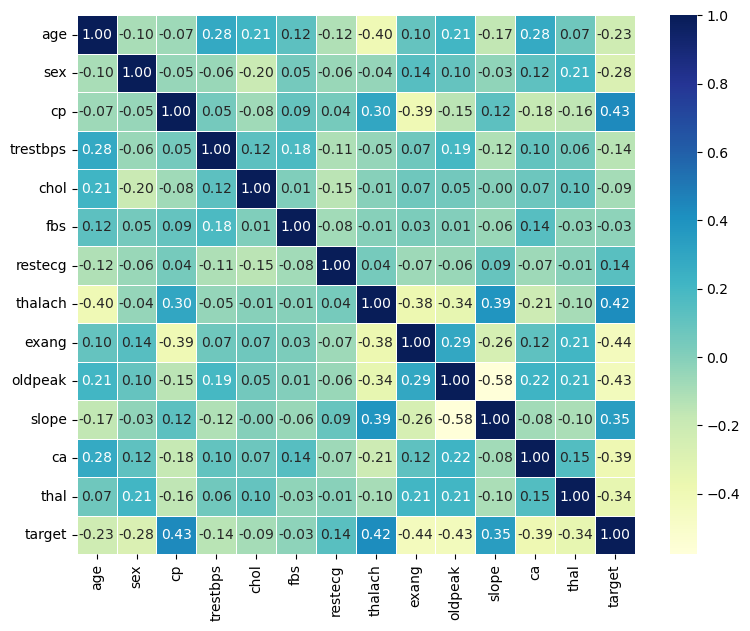

In [14]:
df_original = df.drop(columns=['Age Group'])
corr_matrix = df_original.corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap="YlGnBu", linewidths=0.5)
plt.show()

It appears that most of the features have a similar correlation with the target, around +-0.3 or 0.4, with exception of cholesterol (chol), fasting blood sugar (fbs), and reting electrocardiographic results (restecg).

### Pre processing

In [15]:
# duplicated rows
df_original[df_original.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [16]:
# removing the only duplicated row
df_original.drop_duplicates(inplace=True)

In [17]:
# checking for outliers in the numeric features, using the inter quartile range
q1 = df_original.select_dtypes(include='number').quantile(0.25)
q3 = df_original.select_dtypes(include='number').quantile(0.75)
iqr = q3-q1

df_original.select_dtypes(include='number')[(df_original.select_dtypes(include='number') < q1 - (iqr*1.5)) & (df_original.select_dtypes(include='number') > q3 + (iqr*1.5))].info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       0 non-null      float64
 1   trestbps  0 non-null      float64
 2   chol      0 non-null      float64
 3   thalach   0 non-null      float64
 4   oldpeak   0 non-null      float64
 5   ca        0 non-null      float64
dtypes: float64(6)
memory usage: 16.5 KB


We don't have any outliers in our dataset, since all the values are between 1.5 times away from the interquartile range.

In [18]:
# Scaling the dataset
cols = df_original.select_dtypes(include='number').columns
scaler = StandardScaler().fit(df_original[cols])

df_scaled = df_original.copy()

df_scaled[cols] = scaler.transform(df_original[cols])
df_scaled.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02,3.020000e+02
mean,-2.588070e-16,-7.058372e-16,8.822964e-18,-5.646697e-16,-1.646953e-16,-4.705581e-17
std,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00,1.001660e+00
min,-2.814192e+00,-2.144521e+00,-2.332210e+00,-3.436149e+00,-8.995441e-01,-7.149112e-01
25%,-7.107878e-01,-6.617119e-01,-6.870826e-01,-7.137164e-01,-8.995441e-01,-7.149112e-01
50%,1.195033e-01,-9.140084e-02,-1.161266e-01,1.281605e-01,-2.096081e-01,-7.149112e-01
75%,7.283833e-01,4.789102e-01,5.467629e-01,7.185677e-01,4.803280e-01,2.800344e-01
max,2.499671e+00,3.900776e+00,6.145034e+00,2.292987e+00,4.447460e+00,3.264871e+00


In [19]:
df_scaled.dtypes

age          float64
sex         category
cp          category
trestbps     float64
chol         float64
fbs         category
restecg     category
thalach      float64
exang       category
oldpeak      float64
slope       category
ca           float64
thal        category
target      category
dtype: object

In [20]:
categorical_columns = categorical_columns[:-1]
categorical_columns

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [21]:
len(df_original)

302

In [22]:
# Transforming categorical columns into numeric with one hot encoder
encoder = OneHotEncoder(sparse_output=False)

encoded_df = encoder.fit_transform(df_scaled[categorical_columns])
encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out())
encoded_df = encoded_df.reset_index(drop=True)
num_cols = df_scaled.drop(columns=categorical_columns)
num_cols = num_cols.reset_index(drop=True)

encoded_df = pd.concat([encoded_df, num_cols], axis=1)

### Modeling

In [23]:
# Splitting the data into X and y
X = encoded_df.drop(columns='target')
y = encoded_df['target']

# Splitting the data into train and test 
# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.size, X_test.size

(5486, 2366)

We are going to test the following models:
- Random Forest
- XGBoost
- Logistic Regression
- KNN

In [24]:
models = {
    'Random Forest': [],
    'XGBoost': [],
    'LogisticRegression': [],
    'KNN': []
}

#### Random Forest

In [25]:
# Base Model
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
base_accuracy = clf.score(X_test, y_test)
models['Random Forest'].append(base_accuracy)
print(base_accuracy)

0.8351648351648352


In [26]:
# hypertuning with optuna
def objective_RF(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    max_features = trial.suggest_categorical('max_features', ['log2', 'sqrt', None])
    max_depth = trial.suggest_int('max_depth', 10, 110)
    min_samples_split = trial.suggest_int('min_samples_slit', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=42
    )

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_RF, n_trials=100)

trial = study.best_trial

[I 2024-09-10 14:07:06,020] A new study created in memory with name: no-name-10ac026a-74b5-47e9-bd08-914a13d5ff38
[I 2024-09-10 14:07:09,269] Trial 0 finished with value: 0.810188261351052 and parameters: {'n_estimators': 598, 'max_features': 'sqrt', 'max_depth': 52, 'min_samples_slit': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.810188261351052.
[I 2024-09-10 14:07:13,166] Trial 1 finished with value: 0.8149501661129568 and parameters: {'n_estimators': 1562, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_slit': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8149501661129568.
[I 2024-09-10 14:07:16,617] Trial 2 finished with value: 0.8197120708748615 and parameters: {'n_estimators': 1512, 'max_features': 'log2', 'max_depth': 83, 'min_samples_slit': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8197120708748615.
[I 2024-09-10 14:07:18,062] Trial 3 finished with value: 0.8149501661129568 and parameters: {'n_estimators': 917, 'max_features': 'sqrt'

In [28]:
print("Best trial:")
print(f"Value: {trial.value}")
for k, v in trial.params.items():
    print(f"{k}: {v}")

Best trial:
Value: 0.8339977851605758
n_estimators: 272
max_features: sqrt
max_depth: 69
min_samples_slit: 10
min_samples_leaf: 3


In [29]:
best_params = trial.params
clf_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_slit'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

clf_rf.fit(X_train, y_train)
acc = clf_rf.score(X_test, y_test)
models['Random Forest'].append(acc)

In [30]:
models

{'Random Forest': [0.8351648351648352, 0.8681318681318682],
 'XGBoost': [],
 'LogisticRegression': [],
 'KNN': []}

#### Logistic Regression

In [31]:
# Base Model
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
base_accuracy = clf.score(X_test, y_test)
models['LogisticRegression'].append(base_accuracy)
print(base_accuracy)

0.8461538461538461


In [32]:
# hypertuning with optuna
def objective_LR(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    c = trial.suggest_loguniform('C', 0.0001, 100)

    clf = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=c,
        random_state=42
    )

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_LR, n_trials=100)

trial = study.best_trial
print(f'best run')
print(f'{trial.value}')
for k, v in trial.params.items():
    print(f"{k}: {v}")

[I 2024-09-10 14:09:14,154] A new study created in memory with name: no-name-66b26c45-0091-4956-aa5f-d21b63e68147
C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_1312\97946001.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 0.0001, 100)
[I 2024-09-10 14:09:14,183] Trial 0 finished with value: 0.8387596899224807 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.05026373316594093}. Best is trial 0 with value: 0.8387596899224807.
C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_1312\97946001.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 0.0001, 100)
[I 2024-09-10 14:09:14,211] Trial 1 fi

best run
0.8435215946843855
solver: lbfgs
penalty: l2
C: 0.042299855594255226


In [76]:
clf_lr = LogisticRegression(solver=trial.params['solver'], penalty=trial.params['penalty'], C=trial.params['C'], random_state=42)
clf_lr.fit(X_train, y_train)
acc = clf_lr.score(X_test, y_test)
models['LogisticRegression'].append(acc)
print(acc)

KeyError: 'solver'

#### KNN

In [35]:
# Base Model
clf = KNeighborsClassifier().fit(X_train, y_train)
base_accuracy = clf.score(X_test, y_test)
models['KNN'].append(base_accuracy)
print(base_accuracy)

0.8461538461538461


In [36]:
# hypertuning with optuna
def objective_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 2, 30)

    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors
    )

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_KNN, n_trials=100)

trial = study.best_trial
print(f'best run')
print(f'{trial.value}')
for k, v in trial.params.items():
    print(f"{k}: {v}")

[I 2024-09-10 14:09:16,962] A new study created in memory with name: no-name-e8dd5487-685f-491a-adf7-94a0073829c7
[I 2024-09-10 14:09:17,057] Trial 0 finished with value: 0.796124031007752 and parameters: {'n_neighbors': 9}. Best is trial 0 with value: 0.796124031007752.
[I 2024-09-10 14:09:17,160] Trial 1 finished with value: 0.8151716500553711 and parameters: {'n_neighbors': 30}. Best is trial 1 with value: 0.8151716500553711.
[I 2024-09-10 14:09:17,242] Trial 2 finished with value: 0.8198228128460687 and parameters: {'n_neighbors': 3}. Best is trial 2 with value: 0.8198228128460687.
[I 2024-09-10 14:09:17,268] Trial 3 finished with value: 0.7867109634551495 and parameters: {'n_neighbors': 11}. Best is trial 2 with value: 0.8198228128460687.
[I 2024-09-10 14:09:17,294] Trial 4 finished with value: 0.8102990033222592 and parameters: {'n_neighbors': 21}. Best is trial 2 with value: 0.8198228128460687.
[I 2024-09-10 14:09:17,310] Trial 5 finished with value: 0.8056478405315616 and param

best run
0.8198228128460687
n_neighbors: 3


In [59]:
clf_KNN = KNeighborsClassifier(n_neighbors=26)
clf_KNN.fit(X_train, y_train)
acc = clf_KNN.score(X_test, y_test)
models['KNN'].append(acc)
print(acc)

0.8571428571428571


#### XGBOOST

In [39]:
# Base Model
clf = XGBClassifier()
clf.fit(X_train, y_train)
base_accuracy = clf.score(X_test, y_test)
models['XGBoost'].append(base_accuracy)
print(base_accuracy)

0.8021978021978022


In [50]:
def objective_XGBOOST(trial):
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }

    # Train the model with cross-validation
    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss', random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy').mean()
    
    return score

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_XGBOOST, n_trials=100)

trial = study.best_trial
print(f'best run')
print(f'{trial.value}')
for k, v in trial.params.items():
    print(f"{k}: {v}")

[I 2024-09-10 14:26:51,979] A new study created in memory with name: no-name-f22c8858-572e-48cc-8e6a-115639b37217
[I 2024-09-10 14:26:54,324] Trial 0 finished with value: 0.8196013289036544 and parameters: {'n_estimators': 1289, 'learning_rate': 0.027435538543200265, 'max_depth': 12, 'min_child_weight': 5}. Best is trial 0 with value: 0.8196013289036544.
[I 2024-09-10 14:26:55,947] Trial 1 finished with value: 0.8056478405315615 and parameters: {'n_estimators': 1157, 'learning_rate': 0.03365388298253073, 'max_depth': 4, 'min_child_weight': 1}. Best is trial 0 with value: 0.8196013289036544.
[I 2024-09-10 14:26:57,222] Trial 2 finished with value: 0.8151716500553711 and parameters: {'n_estimators': 536, 'learning_rate': 0.010392249363377721, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 0 with value: 0.8196013289036544.
[I 2024-09-10 14:26:57,482] Trial 3 finished with value: 0.815060908084164 and parameters: {'n_estimators': 1021, 'learning_rate': 0.060934058080136196, 'max_de

best run
0.8624584717607974
n_estimators: 1112
learning_rate: 0.012597128237041181
max_depth: 12
min_child_weight: 3


In [52]:
clf_XGB = XGBClassifier(n_estimators=trial.params['n_estimators'], learning_rate=trial.params['learning_rate'], max_depth=trial.params['max_depth'], min_child_weight=trial.params['min_child_weight'], random_state=42)
clf_XGB.fit(X_train, y_train)
acc = clf_XGB.score(X_test, y_test)
models['XGBoost'].append(acc)
print(acc)

0.8351648351648352


In [61]:
models

{'Random Forest': [0.8351648351648352, 0.8681318681318682],
 'XGBoost': [0.8021978021978022, 0.8351648351648352],
 'LogisticRegression': [0.8461538461538461, 0.8791208791208791],
 'KNN': [0.8461538461538461, 0.8571428571428571]}

In [67]:
best_acc = {}
for k in models.keys():
    best_acc[k] = max(models[k])

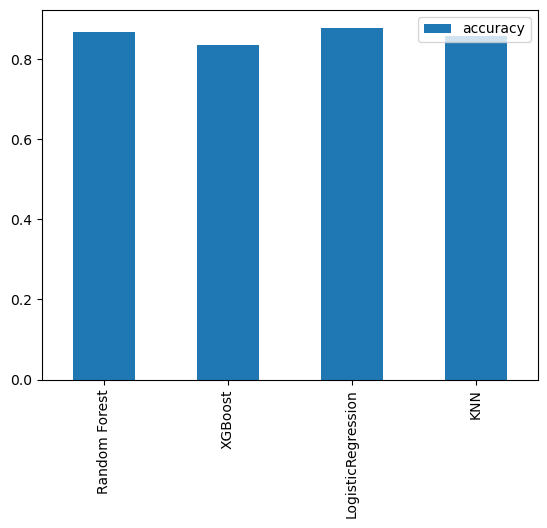

In [75]:
df_models = pd.DataFrame(best_acc, index=['accuracy']).T.plot(kind='bar')

plt.show()

The model with the highest accuracy was Logistic Regression (87.9%). We can check other metrics as well:

In [80]:
y_preds = clf_lr.predict(X_test)

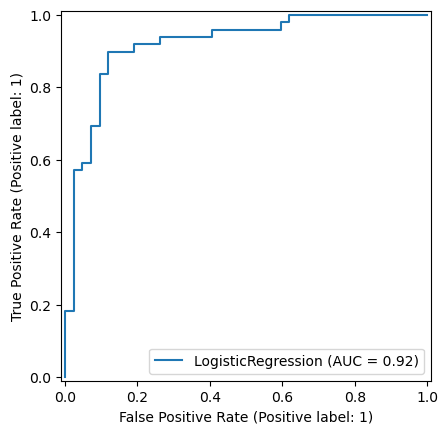

In [79]:
RocCurveDisplay.from_estimator(estimator=clf_lr, X=X_test, y=y_test)

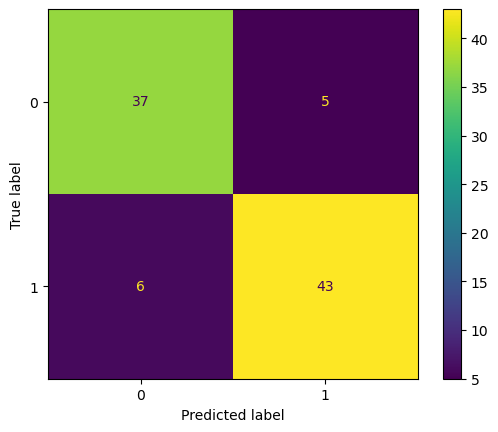

In [84]:
cm = confusion_matrix(y_test, y_preds, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

In [88]:
print(classification_report(y_test, y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8605    0.8810    0.8706        42
           1     0.8958    0.8776    0.8866        49

    accuracy                         0.8791        91
   macro avg     0.8781    0.8793    0.8786        91
weighted avg     0.8795    0.8791    0.8792        91



Feature Importance

In [91]:
features_dict = dict(zip(encoded_df, list(clf_lr.coef_[0])))
features_dict 

{'sex_0': 0.19146787900969633,
 'sex_1': -0.19151907082452338,
 'cp_0': -0.3481223005538338,
 'cp_1': 0.03308958691797541,
 'cp_2': 0.274599744181302,
 'cp_3': 0.040381777639729464,
 'fbs_0': -0.07249816347625748,
 'fbs_1': 0.07244697166143038,
 'restecg_0': -0.09604812761719,
 'restecg_1': 0.116945696980049,
 'restecg_2': -0.02094876117768608,
 'exang_0': 0.24189147692315863,
 'exang_1': -0.24194266873798578,
 'slope_0': -0.01251175022240059,
 'slope_1': -0.19971307234536068,
 'slope_2': 0.21217363075293427,
 'thal_0': 0.010484370804999232,
 'thal_1': 0.012668214691098825,
 'thal_2': 0.3340272743046083,
 'thal_3': -0.35723105161553337,
 'age': -0.041068264594133985,
 'trestbps': -0.10357049117512344,
 'chol': -0.026012763648768845,
 'thalach': 0.3042712704251443,
 'oldpeak': -0.30963714418976207,
 'ca': -0.47012521507443483}

<Axes: title={'center': 'Feature Importance'}>

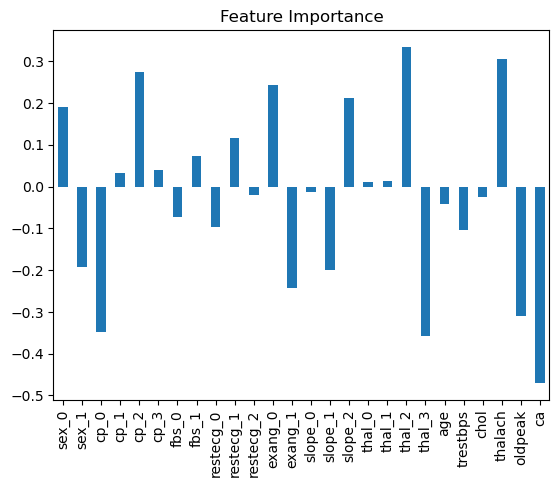

In [93]:
df_features = pd.DataFrame(features_dict, index=[0])
df_features.T.plot.bar(title='Feature Importance', legend=False)